# Importing of Libraries


In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pickle
import matplotlib.pyplot as plt

# Loading of Dataset

In [2]:
df = pd.read_csv('//content/Churn_Modelling.csv')
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# Transformation of Data

In [3]:
preprocessor = ColumnTransformer(
    transformers=[
        ('onehotencoder', OneHotEncoder(drop='first'), ['Geography', 'Gender']),
        ('standardization', StandardScaler(), ['CreditScore', 'Age', 'Tenure', 'Balance',
                                               'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'])
    ],
    remainder='passthrough'
)

# Test Train Split

In [4]:
x = df.drop('Exited', axis=1)
y = df['Exited']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)


# Balancing the Dataset

In [5]:
x_train_processed = preprocessor.fit_transform(x_train)
x_test_processed = preprocessor.transform(x_test)
smote = SMOTE()
x_train_res, y_train_res = smote.fit_resample(x_train_processed, y_train)

In [22]:
from collections import Counter

print("Original training set class distribution:", Counter(y_train))
print("Resampled training set class distribution:", Counter(y_train_res))


Original training set class distribution: Counter({0: 6356, 1: 1644})
Resampled training set class distribution: Counter({0: 6356, 1: 6356})


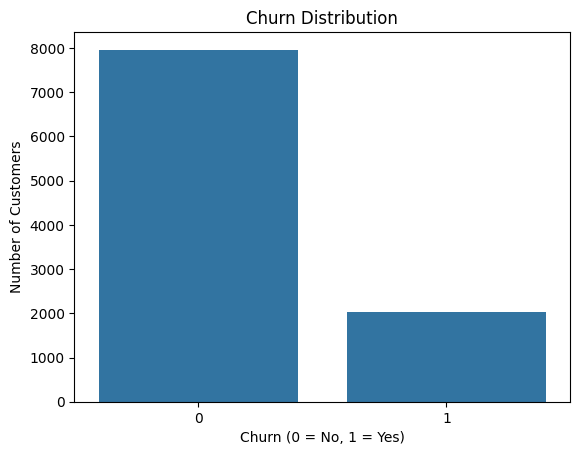

In [25]:
sns.countplot(x='Exited', data=df)
plt.title("Churn Distribution")
plt.xlabel("Churn (0 = No, 1 = Yes)")
plt.ylabel("Number of Customers")
plt.show()

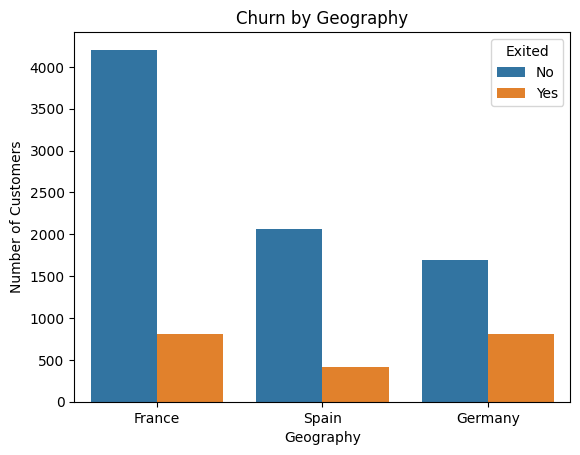

In [26]:
sns.countplot(x='Geography', hue='Exited', data=df)
plt.title("Churn by Geography")
plt.xlabel("Geography")
plt.ylabel("Number of Customers")
plt.legend(title="Exited", labels=["No", "Yes"])
plt.show()


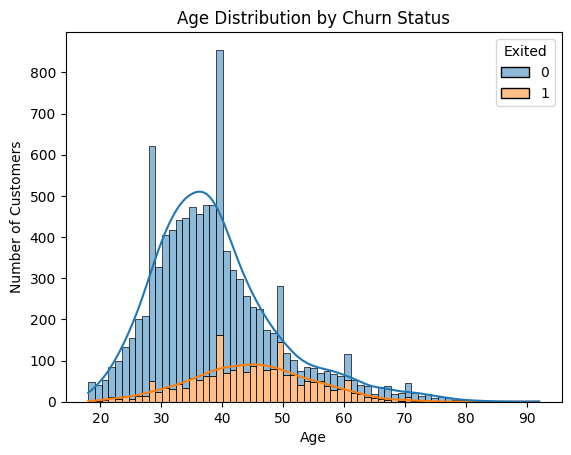

In [27]:
sns.histplot(data=df, x='Age', hue='Exited', kde=True, multiple='stack')
plt.title("Age Distribution by Churn Status")
plt.xlabel("Age")
plt.ylabel("Number of Customers")
plt.show()


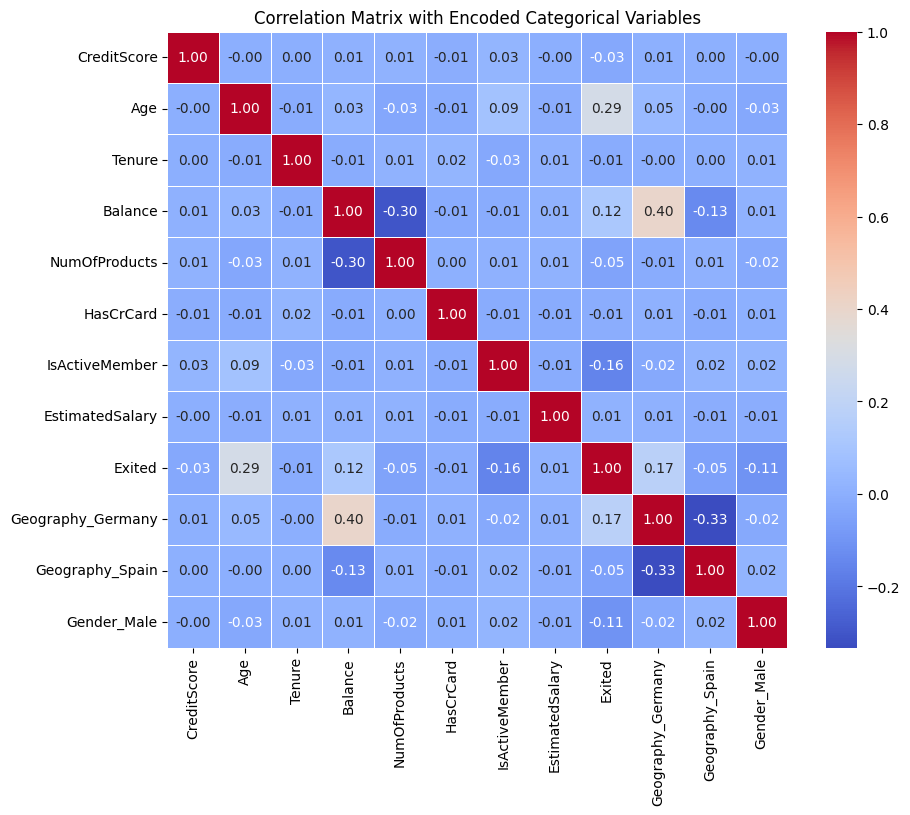

In [30]:

df_encoded = pd.get_dummies(df, columns=['Geography', 'Gender'], drop_first=True)
corr_matrix = df_encoded.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix with Encoded Categorical Variables")
plt.show()


# Models to Train and Evaluate

In [14]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest Classifier": RandomForestClassifier()
}
results = []
for model_name, model in models.items():
    model.fit(x_train_res, y_train_res)
    y_pred = model.predict(x_test_processed)
    results.append({
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred)
    })
final_results = pd.DataFrame(results)

In [15]:
final_results

,Model,Accuracy,Precision,Recall,F1
0,Logistic Regression,0.7220,0.388509,0.722646,0.505338
1,Decision Tree,0.7765,0.445344,0.559796,0.496054
2,Random Forest Classifier,0.8425,0.605978,0.567430,0.586071


In [16]:
rfc = models["Random Forest Classifier"]
pickle.dump(rfc, open('rfc.pkl', 'wb'))
pickle.dump(preprocessor, open('preprocessor.pkl', 'wb'))

# Prediction Function

In [17]:
def predict_churn(CreditScore, Geography, Gender, Age, Tenure, Balance, NumOfProducts,
                  HasCrCard, IsActiveMember, EstimatedSalary):
    input_data = pd.DataFrame([[CreditScore, Geography, Gender, Age, Tenure, Balance,
                                NumOfProducts, HasCrCard, IsActiveMember, EstimatedSalary]],
                              columns=x.columns)
    input_processed = preprocessor.transform(input_data)
    pred = rfc.predict(input_processed)
    return pred[0]

In [19]:
prediction = predict_churn(639, 'Germany', 'Male', 42, 2, 0.00, 1, 1, 1, 112542.58)
print("Prediction:", prediction)

Prediction: 0


In [20]:
final_results

,Model,Accuracy,Precision,Recall,F1
0,Logistic Regression,0.7220,0.388509,0.722646,0.505338
1,Decision Tree,0.7765,0.445344,0.559796,0.496054
2,Random Forest Classifier,0.8425,0.605978,0.567430,0.586071
